In [1]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
from pprint import pprint

import gymnasium as gym

# Postawy Gymnasium - Sprawozdanie
## Kacper Cienkosz, Miłosz Dubiel

Do wykonania uczenia ze wzmocnieniem wybraliśmy środowisko Blackjack oparte na zasadach Suttona & Barto.
Nie będziemy tutaj przywoływać zasad Blackjacka, odsyłamy do [Wikipedii](https://pl.wikipedia.org/wiki/Blackjack) oraz [dokumentacji Gymnasium](https://gymnasium.farama.org/environments/toy_text/blackjack/) gdzie znajdują się sekcje tłumaczące te zasady.

In [2]:
env = gym.make("Blackjack-v1", sab=True)

# Proces ewaluacji podejmowanych akcji
Dla naszego środowiska postanowiliśmy wykorzystać algorytm **Q-learning**

## Q-learning

Algorytm **Q-learning** nie jest algorytmem opartym na całym modelu środowiska (jest *model-free*), co oznacza, że do ewaluacji stanów korzysta z metod różnic tymczasowych (*temporal difference*) i wymaga tylko informacji o stanach środowiska, bez informacji o przejściach pomiędzy nimi.

Strategia wyboru kolejnej akcji w algorytmie **Q-learning** opiera się na tzw. metodzie *ε-greedy*. Polega to na możliwości wyboru najlepszej możliwej akcji z możliwych (zachłannie) z prawdopodobieństwem `1 - ε` lub losowej możliwej akcji z prawdopodobieństwem `ε`. Dzięki temu można zbilansować naukę agenta ze względu na eksploatację najlepszej w danym momencie ścieżki i eksplorację innych możliwych rozwiązań.

W **Q-learning** wybór akcji następuje poprzez ewaluację stanu następującego po wybranej zachłannie akcji. Najpierw następuje określenie, czy wykonana akcja nie kończy procesu (w tym wypadku gry) - wtedy wartość **Q** dla następnej akcji jest zerowa.

Wyliczenie nowej wartości **Q** dla wykonanej akcji następuje zgodnie ze wzorem:
$$
    Q(state_t, action_t) = Q(state_t, action_t) + learning\_rate(reward + discount\_factor * max_{action}(Q(state_{t+1}, action)) - Q(state_t, action_t))
$$

W przypadku poniższego kodu sprowadza się to do tego, że:
  - `future_q_value` := $max_{action}(Q(state_{t+1}, action)$ jeżeli stan nie jest `terminated`, w przeciwnym wypadku $0$
  - `temporal_difference` := $reward + discount\_factor *$ `future_q_value`  $- Q(state_t, action_t)$
I ostatecznie:
  - $Q(state_t, action_t) = Q(state_t, action_t) + learning\_rate * $ `temporal_difference`

$max_{action}(Q(state_{t+1}, action)$ wprowadza nam pewność, że wybierzemy najlepszą możliwą do wykonania akcję w następnym kroku działania agenta.

Źródło: [SKN main Łódź](https://main.p.lodz.pl/news.php?id=124)

W celu ustrukturyzowania procesu uczenia stworzony został `BlackjackAgent`, który pozwala nadać strukturę kolejnym krokom poprzez wykorzystanie odpowiednich metod, tj. inicjalizacji z wymaganymi hiperparametrami, przeliczenie następnej akcji do wykonania (z wprowadzeniem elementu probabilistycznego w celu poznania środowiska), wyznaczeniu wartości funkcji **Q** w celu ewaluacji wykonanej akcji oraz dokonanie zmniejszenia epsilonu.

In [3]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

# Proces uczenia

Na początku standardowo należy dobrać hiperparametry modelu. W przypadku naszego środowiska i agenta do Blackjacka musieliśmy dobrać:
  - `learning_rate`
  - `n_episodes` - liczbę epizodów do przeprowadzenia uczenia
  - `start_epsilon`
  - `epsilon_decay`
  - `final_epsilon`
  - `discount_factor = 0.9` - zgodnie z założeniami zadania

In [4]:
learning_rate = 0.001
n_episodes = 1_000_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2) 
final_epsilon = 0.1

discount_factor = 0.9

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount_factor
)

Sam proces uczenia przebiega w następujący sposób:
  - dla każdego epizodu środowisko musi zostać zresetowane (inaczej stan środowiska będzie wskazywał poprzednią rozgrywkę)
  - dopóki gra nie zostanie zakończona:
     - agent wybiera akcję na podstawie aktualnego stanu środowiska
     - wykonywana jest wybrana akcja (`env.step(action)`)
     - agent aktualizuje swoje zachowania na podstawie stanu po wykonanej akcji
     - następuje przypisanie nowego stanu do aktualnego
  - przed każdym kolejnym epizodem następuje zmniejszenie epsilonu agenta (`agent.decay_epsilon()`)

In [5]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(obs, action, reward, terminated, next_obs)
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 1000000/1000000 [01:04<00:00, 15494.79it/s]


# Wyniki uczenia

Poniżej został zaprezentowany wykres błędu uczenia w kolejnych epizodach w postaci średniej kroczącej jak i wygładzonej średniej kroczącej. Można zauważyć, że model osiągnął błąd zbliżony do 0.

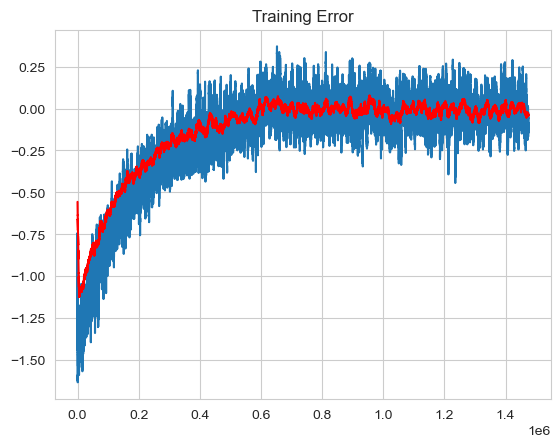

In [6]:
plt.title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(1250), mode="same") / 250
)
plt.plot(training_error_moving_average)
plt.rcParams["figure.figsize"] = (20,8)
training_error_moving_average_smooth = (
    np.convolve(np.array(agent.training_error), np.ones(10000), mode="same") / 2500
)
plt.plot(training_error_moving_average_smooth, 'r')
plt.show()

### Zobrazowanie polityki modelu

Na podstawie wyznaczonych w procesie uczenia **Q** wartości jesteśmy w stanie wyznaczyć, z jaką polityką agent będzie reagował na dany stan rozgrywki.

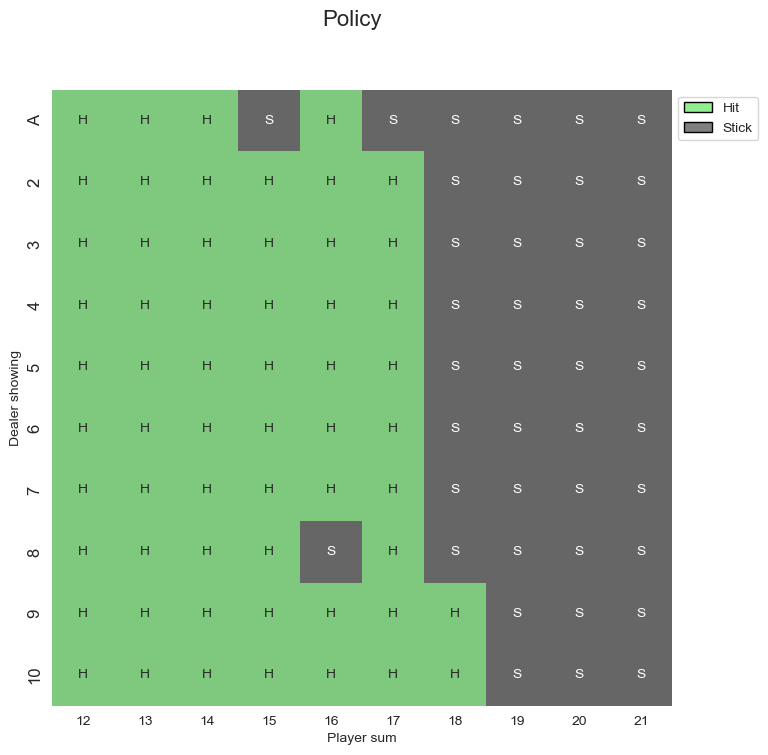

In [7]:
state_value = defaultdict(float)
policy = defaultdict(int)
for obs, action_values in agent.q_values.items():
    state_value[obs] = float(np.max(action_values))
    policy[obs] = int(np.argmax(action_values))

player_count, dealer_count = np.meshgrid(np.arange(12, 22), np.arange(1, 11))

policy_grid = np.apply_along_axis(
    lambda obs: policy[(obs[0], obs[1], True)],
    axis=2,
    arr=np.dstack([player_count, dealer_count]),
)
policy_grid_str = []
for row in policy_grid:
    policy_grid_str.append([])
    for value in row:
        policy_grid_str[-1].append("H" if value else "S")
    
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Policy", fontsize=16)
    
fig.add_subplot(1, 1, 1)
ax = sns.heatmap(policy_grid, annot=np.array(policy_grid_str), fmt="", cmap="Accent_r", cbar=False)
ax.set_xlabel("Player sum")
ax.set_ylabel("Dealer showing")
ax.set_xticklabels(range(12, 22))
ax.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

legend_elements = [
    Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
    Patch(facecolor="grey", edgecolor="black", label="Stick"),
]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.15 , 1))
   
plt.show()

Jak widać na powyższym diagramie, gdy suma kart agenta jest mniejsza lub równa 17, to agent pociągnie kolejną kartę, oprócz sytuacji, gdy suma kart agenta wynosi 15, a dealer ma asa, gdy suma kart agenta wynosi 16, a dealera 8 lub gdy suma kart agenta wynosi 17, a dealer ma asa. 

Dodatkowo pociągnięcie kolejnej karty ma również miejsce w dwóch sytuacjach: gdy suma kart agenta wynosi 18, a suma kart dealera wynosi 10 lub 9. 

W pozostałych przypadkach agent zostanie przy aktualnie posiadanym rozdaniu i nie pociągnie kolejnej karty.

# Wizualizacja rozgrywki

Tworzymy nowe środowisko testowe, które będzie służyło do wizualizacji rozgrywki. Dodatkowo tworzymy listę wyników z odbytych gier.

In [8]:
test_env = gym.make("Blackjack-v1", sab=True, render_mode='human')
num_test_episodes = 100

DISPLAY_EPISODE_RESULTS = False

episode_results = []

for episode in tqdm(range(num_test_episodes)):
    obs, _ = test_env.reset()
    done = False

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, _ = test_env.step(action)
        done = terminated or truncated
        obs = next_obs
        
        if done:
            episode_result = f"Episode {episode + 1}: Agent sum: {obs[0]} | Dealer showing: {obs[1]}, {'Dealer wins' if 21 >= obs[1] > obs[0] else ('Agent wins' if obs[0] <= 21 else 'Agent busts')}"
            episode_results.append(episode_result)
            
            if DISPLAY_EPISODE_RESULTS:
                print(episode_result)
    
        # This method is commented out because as far as I'm concerned env renders itself automatically when render_mode is set 
        # test_env.render()

if not DISPLAY_EPISODE_RESULTS:
    pprint(episode_results)

100%|██████████| 100/100 [01:03<00:00,  1.58it/s]

['Episode 1: Agent sum: 20 | Dealer showing: 8, Agent wins',
 'Episode 2: Agent sum: 24 | Dealer showing: 9, Agent busts',
 'Episode 3: Agent sum: 24 | Dealer showing: 10, Agent busts',
 'Episode 4: Agent sum: 17 | Dealer showing: 7, Agent wins',
 'Episode 5: Agent sum: 21 | Dealer showing: 8, Agent wins',
 'Episode 6: Agent sum: 19 | Dealer showing: 10, Agent wins',
 'Episode 7: Agent sum: 16 | Dealer showing: 6, Agent wins',
 'Episode 8: Agent sum: 17 | Dealer showing: 5, Agent wins',
 'Episode 9: Agent sum: 17 | Dealer showing: 10, Agent wins',
 'Episode 10: Agent sum: 24 | Dealer showing: 10, Agent busts',
 'Episode 11: Agent sum: 15 | Dealer showing: 2, Agent wins',
 'Episode 12: Agent sum: 20 | Dealer showing: 5, Agent wins',
 'Episode 13: Agent sum: 12 | Dealer showing: 10, Agent wins',
 'Episode 14: Agent sum: 19 | Dealer showing: 8, Agent wins',
 'Episode 15: Agent sum: 24 | Dealer showing: 7, Agent busts',
 'Episode 16: Agent sum: 21 | Dealer showing: 5, Agent wins',
 'Episod